Following Khomyakov's trouble-shooting tips in https://arxiv.org/pdf/cond-mat/0501609.pdf

In [49]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int
    L : int
    a : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
from scipy.linalg import orth

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
params = JosephsonParameters(W = 10 , 
                             L = 10,
                             t = 1,
                             a = 1 , 
                             flux = 0,
                             energy = 0.5,
                             Delta = 0,
                             phase = 0,
                             mu = 1.2,
                            tol = 1e-4)



In [68]:
def mode_sorting(eigenvalues , eigenvectors , params , slice):
    # each eigenvector is formed of amplitudes (c_{i} , c_{i-1}). We want the lower block:
    vectors = eigenvectors[int(eigenvectors.shape[0]/2) : , :]

    # We now want a matrix of norms. The column vectors in vectors may not necessarily be orthogonal but this is fine.
    norms = np.diagonal(np.conj(vectors.T) @ vectors)
    normalisation_factors = 1 / np.sqrt(norms)
    normalisation_factor_matrix = np.diag(normalisation_factors)

    normalised_vectors = vectors @ normalisation_factor_matrix

    # Eigenvalues corresponding to states that decay in the positive x direction:
    pos_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) < -params.tol]
    # Eigenvalues corresponding to states that evanesce in the negative x direction:
    neg_e_evals = eigenvalues[(np.abs(eigenvalues) - 1) > params.tol]

    # Compute the group velocity for each state:
    group_velocities = np.zeros(vectors.shape[1])
    for i in range(vectors.shape[1]):
        group_velocities[i] = so.group_vel(normalised_vectors[: , i], eigenvalues[i] , slice , params)

    # Sorting propagating modes according to sign of group velocity:
    p_conditions = (np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities > 0)
    n_conditions =(np.abs((np.abs(eigenvalues) - 1)) <= params.tol) & (group_velocities < 0 )

    pos_p_evals = eigenvalues[ p_conditions ]
    neg_p_evals = eigenvalues[ n_conditions]

    # Sorting normalised eigenvectors in the same way:
    pos_prop = normalised_vectors[: , p_conditions]
    neg_prop = normalised_vectors[: , n_conditions]

    pos_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) < -params.tol]
    neg_evanesce = normalised_vectors[: , (np.abs(eigenvalues) - 1) > params.tol]
    
    list_of_eigenvalues = [pos_p_evals , neg_p_evals , pos_e_evals , neg_e_evals]

    # group_velocities for propgating states only:
    g_vel_p = group_velocities[p_conditions]
    g_vel_n = group_velocities[n_conditions]
     
    return pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , [group_velocities , g_vel_p , g_vel_n]
    
def generalised_eigenvalue_problem(slice , params):
    energy = params.energy
    M00 = np.linalg.inv(so.T(slice+1 , -1, params))@(energy*np.identity(params.W) -  so.h_0(slice , params)) # <- Calculating the Hamiltonian at slice.
    M01 = -np.linalg.inv(so.T(slice+1 , -1, params))@so.T(slice , +1 , params)
    M10 = np.identity(params.W)
    M11 = np.zeros(shape = (params.W , params.W))

    M = np.block([[M00 , M01],[M10 , M11]]) #<- Matrix to diagonalise for propagating modes in lead

    # evals are bloch factors, evecs are transverse mode eigenvfunctions for sites: (slice , slice -1)^{T}
    evals , evecs = np.linalg.eig(M)

    pos_prop , neg_prop , pos_evanesce , neg_evanesce , list_of_eigenvalues , gv = mode_sorting(evals , evecs ,params , slice)

    # Constructing U(±), matrices of right and left going eigenvectors:
    U_pos = np.hstack((pos_prop , pos_evanesce))
    U_neg = np.hstack((neg_prop , neg_evanesce)) 

    # Constructing A(±) , diagonal matrix of bloch factors:
    Lambda_pos = np.diag(np.hstack((list_of_eigenvalues[0] ,list_of_eigenvalues[2])))
    Lambda_neg = np.diag(np.hstack((list_of_eigenvalues[1] , list_of_eigenvalues[3])))

    # Construct the F(\pm) transfer matrices:
    F_pos = U_pos @ Lambda_pos @ np.linalg.inv(U_pos)
    F_neg = U_neg @ Lambda_neg @ np.linalg.inv(U_neg)

        # This is for diagnostic purposes:
    debugdict = {'U_pos' : U_pos , 'U_neg' : U_neg , 'Lambda_pos' : Lambda_pos , 'Lambda_neg': Lambda_neg
                 , 'pos_prop' : pos_prop , 'neg_prop' : neg_prop , 'pos_evanesce' : pos_evanesce , 'neg_evanesce' : neg_evanesce
                 ,'list_of_eigenvalues' : list_of_eigenvalues , 'group_velocities' : gv, 'evals': evals , 'evecs': evecs}

    return F_pos , F_neg , debugdict

def compute_transmission_matrix(lead_indices , params):
    """
    Uses the recursive Greens function algorithm to compute diagonal and off-diagonal Greens functions between the two leads.

    Arguments:
    lead_indices: list , indices of lead slices that are connected to the scattering region.
    params: system parameters 

    returns:
    [GF_diagonal , GF_off_diagonal] : list , diagonal and off-diagonal greens functions for the system.
    """

    # Indices of site in left and right lead that are connected to the scattering region:
    #  Lead  *  Scattering  * Lead
    # -L-L-L-L-S-S-S...-S-S-R-R-R-R-
    #       -0-1-2-3.....-L-L+1

    slice_left = lead_indices[0]
    slice_right = lead_indices[1]

    F_pos_left , F_neg_left , debug_left = generalised_eigenvalue_problem(slice_left - 1 , params)
    F_pos_right , F_neg_right , debug_right = generalised_eigenvalue_problem(slice_right + 1 , params)

    H_start_tilde = so.h_0(slice_left , params) - so.T(slice_left , +1 , params)@np.linalg.inv(F_neg_left)
    H_end_tilde = so.h_0(slice_right , params) - so.T(slice_right+1 , -1 , params)@F_pos_right

    # Number of slices in the scattering region + adjacent slices in lead:
    no_steps = params.L + 2
    
     # Storing tilde Hamiltonians in an array:
    H_tildes = np.zeros(shape = ( H_start_tilde.shape[0] , H_start_tilde.shape[0] , no_steps))
    H_tildes[: , : , 0] = H_start_tilde
    H_tildes[: , : ,-1] = H_end_tilde
    for j in range(1,params.L + 1):
        H_tildes[: , : , j] = so.h_0(j , params)

    # Source term at the left lead:
    source_term = so.T(slice_left , +1 , params) @(np.linalg.inv(F_pos_left) - np.linalg.inv(F_neg_left))
    
    # Recursive step:
    G_start = np.linalg.inv(params.energy*np.identity(params.W) - H_start_tilde)    
    
    diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps))
    off_diag_greensfunctions = np.zeros(shape = (params.W , params.W , no_steps))
    # Initial condition:
    diag_greensfunctions[: , : , 0] = G_start
    off_diag_greensfunctions[: , : , 0] = G_start

    for i in range(no_steps):
        if i > 0:
            matrix = (params.energy*np.identity(params.W)  - H_tildes[: , : , i] -
                                                        so.T(i , +1 , params) @ diag_greensfunctions[: , : , i-1] @ so.T(i , -1 , params) )
            diag_greensfunctions[: , : , i] = np.linalg.inv(matrix)
            off_diag_greensfunctions[: , : , i] = diag_greensfunctions[: , : , i]@ so.T(i , +1 , params) @ off_diag_greensfunctions[: , : , i-1]
        
    U_pos_left = debug_left['U_pos']
    U_pos_right = debug_right['U_neg']
    
    # Non-physical transmission matrix (inludes matrix elements between evanescent waves too, so not physical):  
    tau = np.linalg.inv(U_pos_right)@off_diag_greensfunctions[: , : , -1]@source_term@U_pos_left

    # For the physical transmission matrix, we must compute matrix-elements only between propagating states:
    U_pos_prop_left = debug_left['pos_prop']
    U_pos_prop_right = debug_right['neg_prop']

    transmission = np.linalg.pinv(U_pos_prop_right)@off_diag_greensfunctions[: , : , -1]@source_term@U_pos_prop_left

    # Normalise with respect to group_velocities of propagating modes in each lead:
    g_vel_left = debug_left['group_velocities'][1]
    g_vel_right = debug_right['group_velocities'][1]

    normalisation_matrix = np.sqrt(np.outer(g_vel_right , 1/g_vel_left))

    transmission_normalized = normalisation_matrix * transmission
    return transmission , transmission_normalized


In [69]:
lead_indices = [0 , params.L + 1]

transmission, norm_trans = compute_transmission_matrix(lead_indices , params)

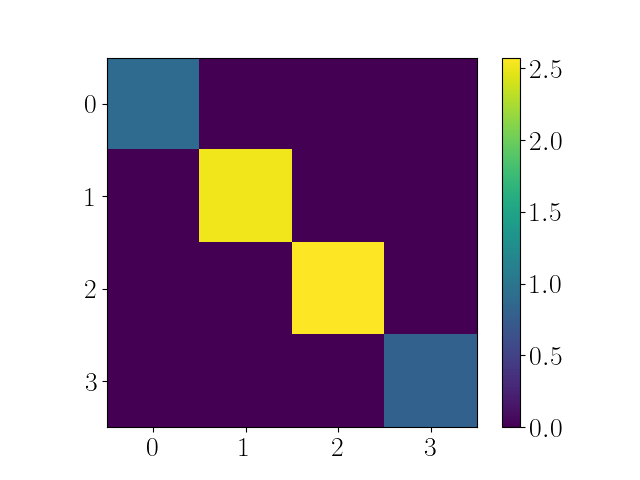

In [70]:
plt.figure()
plt.imshow(np.abs(transmission))
plt.colorbar()

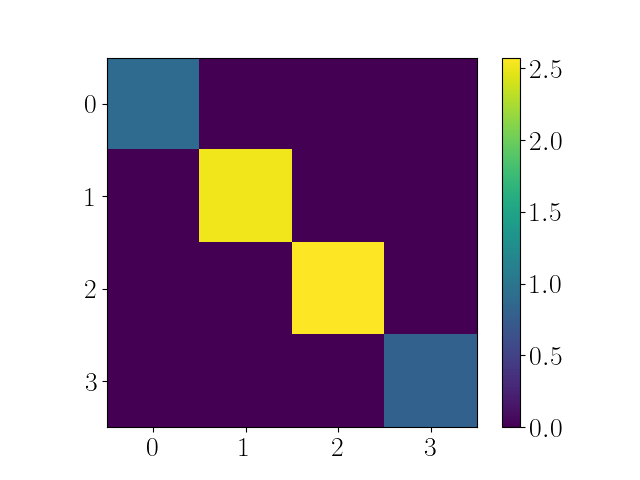

In [71]:
plt.figure()
plt.imshow(np.abs(norm_trans))
plt.colorbar()
